In [3]:
#Set Up Modules:
#--------------------------------------------------------------------------------------
import numpy as np                 #library for working with arrays
import matplotlib.pyplot as plt    #libary for plotting (extension of numpy)
import re as regex                 #library for regular expressions
import cv2                         #libary to solve computer vision problems
import math                        #math tools
import random                      #library for randomization tools
import time                        #library for timing tools
import statistics as stat
import pickle

import winsound
import os, sys
from os import listdir, makedirs   #to use "listdir" and "mkdir"
from os.path import isfile, join, exists   #to use file tools
import copy


#Functions I wrote:
#-------------------------------------------------------------------
import CustomAssertions
import Distance
import Imaging
from Imaging import FrameManager, Background, CustomImage
import FeatureTools
import HandAssessments
from Analysis import StopWatch

ImageSize = 100

In [4]:
#Manually Select Bounding Boxes that do NOT contain any cardboard boxes
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
def WriteLabelAndImageToFile(pathToImageFolder, imageName, buff, img):
    pathToLabel = pathToImageFolder + '\\' + imageName + ".txt"
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    if os.path.isfile(pathToLabel):
        os.remove(pathToLabel)
    file = open(pathToLabel, 'a')
    for i in buff:
        file.write(i + "\n")
    cv2.imwrite(pathToImage, img)
    file.close() 
    
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data\01-RawData_BadImagesRemoved"
ResultsSubfolder = r"04-Data\02-RawData_GroundTruths"
fileSearchRE = "ezgif-frame-[0-9]+.jpg"

#---images to capture
yz_distance  = [[20,40],[40,30],[40,40],[60,40]]
yz_distance  = [[40,30],[40,40],[60,40]]
x_distance   = [1,2,3,4,5]

#---options
imgShrinkFactor = 0.30 #% (fraction) of current size (keep aspect ratio)
singleStrat = False

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
#initialize overall timing stuff
for yz in yz_distance:
    yz_String = "%daway%dhigh" % (yz[0], yz[1])
    for x in x_distance:
        x_String = "X_Position%d" % (x)
        SelectiveSearchModel = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        print("-----> Looking at: " + r"%s/%s" % (yz_String, x_String))

        #grab new frame manager
        frameManager = FrameManager(yz_String, x_String, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
        if frameManager._managerStatus is -1:
            continue

        #run algorithm for one set of images            
        print("Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no")
        while(frameManager.imagesOnStack >=1): 
            #set image into selective search process and run to get boxes
            frameManager.setNextFrame()   #get next frame on stack
            c_Frame = frameManager.getCurrentFrame()
            print("----> Frame: ", frameManager.currentImageName)
            imgSize = np.shape(c_Frame.image)
            img = cv2.resize(c_Frame.image, (int(imgShrinkFactor*imgSize[1]), int(imgShrinkFactor*imgSize[0])), interpolation=cv2.INTER_AREA)
            SelectiveSearchModel.setBaseImage(img)
            SelectiveSearchModel.switchToSelectiveSearchFast()
            if singleStrat == True: SelectiveSearchModel.switchToSingleStrategy()   
            rects = SelectiveSearchModel.process()
            
            #decide which of the boxes in the images are "NOT BOX" images
            buffer = []
            for (x, y, w, h) in rects:
                output = img.copy()
#                 randColor =[random.randint(0, 255) for j in range(0, 3)]
                randColor = [99, 89, 223]
                cv2.rectangle(output, (x, y), (x + w, y + h), randColor, 2)
                
                while True:
                    cv2.imshow("image", output)
                    key = cv2.waitKey(1) & 0xFF

                    #options
                    if   key == ord("y"):   break
                    elif key == ord("n"): buffer.append(str((x, y, w, h))); break
                    elif key == ord("b"): buffer=[]; print(buffer); break
                    elif key == ord("p"): print(buffer); break
                    elif key == ord("s"): print("Skipping box, moving on to next one..."); break
                    elif key == ord("c") or key == ord("q"):  #break, and go to next image
                        break

                #what to do now?
                if key == ord("q"): #quit
                    print("writing buffer to file...")
                    WriteLabelAndImageToFile(frameManager.fullPathToResults, frameManager.currentImageName.split('.')[0], buffer, img)
                    cv2.destroyAllWindows()  
                    sys.exit()
                    break
                if key == ord("c"): #skip image, go to next
                    break
                        
            #write labels to file if buffer is not empty
            if len(buffer) > 0:
                print("writing buffer to file...")
                WriteLabelAndImageToFile(frameManager.fullPathToResults, frameManager.currentImageName.split('.')[0], buffer, img)

            #close image window
            cv2.destroyAllWindows()         

            #what to do now?
            if key == ord("q"): #quit
                sys.exit(0)
                break
            if key == ord("n"): #skip image, go to next
                break



-----> Looking at: 40away30high/X_Position1
Number of images found -->  109
Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no
----> Frame:  ezgif-frame-001.jpg


KeyboardInterrupt: 

In [5]:
#Verify boxes in images are suitable (that they do NOT contain cardboard boxes); autonomously generate samples
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
def WriteImageToFile(pathToImageFolder, imageName, img):
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    cv2.imwrite(pathToImage, img)
    
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data\02-RawData_GroundTruths_NOTBOXES"
ResultsSubfolder = r"04-Data\03-RawData_NOTBOXES_Images"
fileSearchRE = "ezgif-frame-[0-9_]+.jpg"

#---images to capture
yz_distance  = [[20,40],[40,30],[40,40],[60,40]]
yz_distance  = [[20,40]]
x_distance   = [1,2,3,4,5]

#---options
singleStrat = False

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
count = -1
#initialize overall timing stuff
for yz in yz_distance:
    yz_String = "%daway%dhigh" % (yz[0], yz[1])
    for x in x_distance:
        x_String = "X_Position%d" % (x)
        print("-----> Looking at: " + r"%s/%s" % (yz_String, x_String))

        #grab new frame manager
        frameManager = FrameManager(yz_String, x_String, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
        if frameManager._managerStatus is -1:
            continue

        #run algorithm for one set of images            
        print("Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no")
        while(frameManager.imagesOnStack >=1): 
            #set image into selective search process and run to get boxes
            frameManager.setNextFrame()   #get next frame on stack
            c_Frame = frameManager.getCurrentFrame()
            img = c_Frame.image
            print("Parsing sub-images from Frame--->", frameManager.currentImageName)
            
            #read text file to get boxes:
            box_Coordinates = open(r"%s/%s.txt" % (frameManager.fullPathToSource,frameManager.currentImageName.split('.')[0]), 'r')
            content = box_Coordinates.readlines()
            box_Coordinates.close()
            
            #convert string to tuples
            boxTuple = []
            for line in content:
                line = line.replace('(','').replace(')','')
                boxTuple.append(tuple(map(int, line.split(','))))
            
            #print all boxes to image to ensure all are acceptable boxes
            test = img.copy()
            for (x, y, w, h) in boxTuple:
                randColor = [99, 89, 223]
                cv2.rectangle(test, (x, y), (x + w, y + h), randColor, 2)
#             Imaging.showImage(test)
            
            #parse out all sub-images from original image
            for (x, y, w, h) in boxTuple:
                count += 1
                output = img[y:y+h, x:x+w]
                output = cv2.resize(output, (ImageSize, ImageSize), interpolation=cv2.INTER_AREA)
                WriteImageToFile(frameManager.fullPathToResults, "%d%d%d_%d_%s" % (yz[0], yz[1], x, count,"NOTBOX"), output)

-----> Looking at: 20away40high/X_Position1
Number of images found -->  13
Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no
Parsing sub-images from Frame---> ezgif-frame-017.jpg
Parsing sub-images from Frame---> ezgif-frame-024.jpg
Parsing sub-images from Frame---> ezgif-frame-030.jpg
Parsing sub-images from Frame---> ezgif-frame-037.jpg
Parsing sub-images from Frame---> ezgif-frame-039.jpg
Parsing sub-images from Frame---> ezgif-frame-044.jpg
Parsing sub-images from Frame---> ezgif-frame-047.jpg
Parsing sub-images from Frame---> ezgif-frame-054.jpg
Parsing sub-images from Frame---> ezgif-frame-062.jpg
Parsing sub-images from Frame---> ezgif-frame-065.jpg
Parsing sub-images from Frame---> ezgif-frame-070.jpg
Parsing sub-images from Frame---> ezgif-frame-073.jpg
Parsing sub-images from Frame---> ezgif-frame-088.jpg
-----> Looking at: 20away40high/X_Position2
Number of images found -->  14
Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no
Parsing su

In [ ]:
#Manually Select Boxes [ENSURE SIZE OF IMAGES WAS SAME AS THOSE FOR NON-BOX IMAGES]
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data\01-RawData_BadImagesRemoved"
ResultsSubfolder = r"04-Data\02-RawData_GroundTruths_BOXES"
fileSearchRE = "ezgif-frame-[0-9]+.jpg"

#---images to capture
yz_distance  = [[20,40],[40,30],[40,40],[60,40]]
x_distance   = [1,2,3,4,5]

#---options
imgShrinkFactor = 0.30 #% (fraction) of current size (keep aspect ratio)
global x_start, y_start, x_end, y_end, buffer, copyimg

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
def CROP(event, x, y, flags, param):
    # grab references to the global variables
    global x_start, y_start, x_end, y_end, buffer, copyimg
    
    if event == cv2.EVENT_LBUTTONDOWN:
        x_start, y_start = x, y
    elif event == cv2.EVENT_LBUTTONUP:
        x_end, y_end = min(x,np.shape(copyimg)[1]-1), min(y,np.shape(copyimg)[0]-1)
        buffer.append(tuple([x_start, y_start, x_end-x_start, y_end-y_start, int(x_start + 0.5*(x_end-x_start)), int(y_start + 0.5*(y_end-y_start))]))
        print(buffer)
        copyimg = cv2.rectangle(copyimg, (x_start, y_start), (x_end, y_end), [99, 89, 223], 1)

def WriteLabelAndImageToFile(pathToImageFolder, imageName, buff, img):
    pathToLabel = pathToImageFolder + '\\' + imageName + ".txt"
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    if os.path.isfile(pathToLabel):
        os.remove(pathToLabel)
    file = open(pathToLabel, 'a')
    for i in buff:
        file.write(str(i) + "\n")
    cv2.imwrite(pathToImage, img)
    file.close() 
        
#initialize overall timing stuff
for yz in yz_distance:
    yz_String = "%daway%dhigh" % (yz[0], yz[1])
    for x in x_distance:
        #get selective search model
        x_String = "X_Position%d" % (x)
        print("-----> Looking at: " + r"%s/%s" % (yz_String, x_String))

        #grab new frame manager
        frameManager = FrameManager(yz_String, x_String, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
        if frameManager._managerStatus is -1:
            continue

        #run algorithm for one set of images    
        color = [99, 89, 223]
        while(frameManager.imagesOnStack >=1): 
            buffer = []

            #set image into selective search process and run to get boxes
            frameManager.setNextFrame()   #get next frame on stack
            c_Frame = frameManager.getCurrentFrame()
            imgSize = np.shape(c_Frame.image)
            img = cv2.resize(c_Frame.image, (int(imgShrinkFactor*imgSize[1]), int(imgShrinkFactor*imgSize[0])), interpolation=cv2.INTER_AREA)
            print(np.shape(img))
            #set window where clicks should register
            cv2.namedWindow("image")
            cv2.setMouseCallback("image", CROP)            
            
            copyimg = copy.deepcopy(img)
            while True:
                cv2.imshow("image", copyimg)
                key = cv2.waitKey(1) & 0xFF
                
                #options
                if key == ord("b"): copyimg = copy.deepcopy(img); buffer = []
                elif key == ord("u"): 
                    print("Updating Image")
                    for buff in buffer:
                        copyimg = cv2.rectangle(copyimg, (buff[0], buff[1]), (buff[0]+buff[2], buff[1]+buff[3]), [99, 89, 223], 1)
                elif key == ord("p"): print("Buffer:", buffer); 
                elif key == ord("c"): print("Going to next image..."); break 
                elif key == ord("s"): print("Going to next image set..."); break
                elif key == ord("q"): print("Quitting..."); break

            #what to do now?
            if len(buffer) > 0:
                WriteLabelAndImageToFile(frameManager.fullPathToResults, frameManager.currentImageName.split('.')[0], buffer, img)
            cv2.destroyAllWindows()  
            
            if key == ord("q"): #quit
                print("Writing buffer to file...")
                sys.exit()
            if key == ord("s"): #skip image, go to next
                break
            

import winsound
winsound.PlaySound('SystemExclamation',winsound.SND_ALIAS)
print("Main: All images finished.")

In [6]:
#Verify boxes in images are suitable (that they do NOT contain cardboard boxes); autonomously generate samples
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------
def WriteImageToFile(pathToImageFolder, imageName, img):
    pathToImage = pathToImageFolder + '\\' + imageName + ".jpg"
    cv2.imwrite(pathToImage, img)
    
#------------------------------------------ INITIALIZATION SECTION -----------------------------------------------
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data\02-RawData_GroundTruths_BOXES"
ResultsSubfolder = r"04-Data\03-RawData_BOXES_Images"
fileSearchRE = "ezgif-frame-[0-9_]+.jpg"

#---images to capture
yz_distance  = [[20,40],[40,30],[40,40],[60,40]]
yz_distance  = [[20,40]]
x_distance   = [1,2,3,4,5]

#---options
singleStrat = False

#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
count = -1
#initialize overall timing stuff
for yz in yz_distance:
    yz_String = "%daway%dhigh" % (yz[0], yz[1])
    for x in x_distance:
        x_String = "X_Position%d" % (x)
        print("-----> Looking at: " + r"%s/%s" % (yz_String, x_String))

        #grab new frame manager
        frameManager = FrameManager(yz_String, x_String, rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
        if frameManager._managerStatus is -1:
            continue

        #run algorithm for one set of images            
        print("Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no")
        while(frameManager.imagesOnStack >=1): 
            #set image into selective search process and run to get boxes
            frameManager.setNextFrame()   #get next frame on stack
            c_Frame = frameManager.getCurrentFrame()
            img = c_Frame.image
            print("Parsing sub-images from Frame--->", frameManager.currentImageName)
            
            #read text file to get boxes:
            box_Coordinates = open(r"%s/%s.txt" % (frameManager.fullPathToSource,frameManager.currentImageName.split('.')[0]), 'r')
            content = box_Coordinates.readlines()
            box_Coordinates.close()
            
            #convert string to tuples
            boxTuple = []
            for line in content:
                line = line.replace('(','').replace(')','')
                boxTuple.append(tuple(map(int, line.split(','))))
            
            #print all boxes to image to ensure all are acceptable boxes
            test = img.copy()
            for (x, y, w, h, _, _) in boxTuple:
                randColor = [99, 89, 223]
                cv2.rectangle(test, (x, y), (x + w, y + h), randColor, 2)
#             Imaging.showImage(test)
            
            #parse out all sub-images from original image
            for (x, y, w, h, x_center, y_center) in boxTuple:
                count += 1
                output = img[y:y+h, x:x+w]
                output = cv2.resize(output, (ImageSize, ImageSize), interpolation=cv2.INTER_AREA)
                #Images are labeled [z_y_x]
                WriteImageToFile(frameManager.fullPathToResults, "%d_%d_%d_%d_%s" % (yz[0], y_center, x_center, count,"BOX"), output)

-----> Looking at: 20away40high/X_Position1
Number of images found -->  33
Does this box have ANY portion of the CARDBOARD BOX? (y)-yes, (n)-no
Parsing sub-images from Frame---> ezgif-frame-012.jpg
Parsing sub-images from Frame---> ezgif-frame-015.jpg
Parsing sub-images from Frame---> ezgif-frame-018.jpg
Parsing sub-images from Frame---> ezgif-frame-021.jpg
Parsing sub-images from Frame---> ezgif-frame-024.jpg
Parsing sub-images from Frame---> ezgif-frame-027.jpg
Parsing sub-images from Frame---> ezgif-frame-030.jpg
Parsing sub-images from Frame---> ezgif-frame-033.jpg
Parsing sub-images from Frame---> ezgif-frame-036.jpg
Parsing sub-images from Frame---> ezgif-frame-039.jpg
Parsing sub-images from Frame---> ezgif-frame-041.jpg
Parsing sub-images from Frame---> ezgif-frame-043.jpg
Parsing sub-images from Frame---> ezgif-frame-045.jpg
Parsing sub-images from Frame---> ezgif-frame-046.jpg
Parsing sub-images from Frame---> ezgif-frame-048.jpg
Parsing sub-images from Frame---> ezgif-frame-

Number of images found -->  2353
Shape of Images: (2353, 100, 100, 3)
Shape of Labels: (2353, 2)


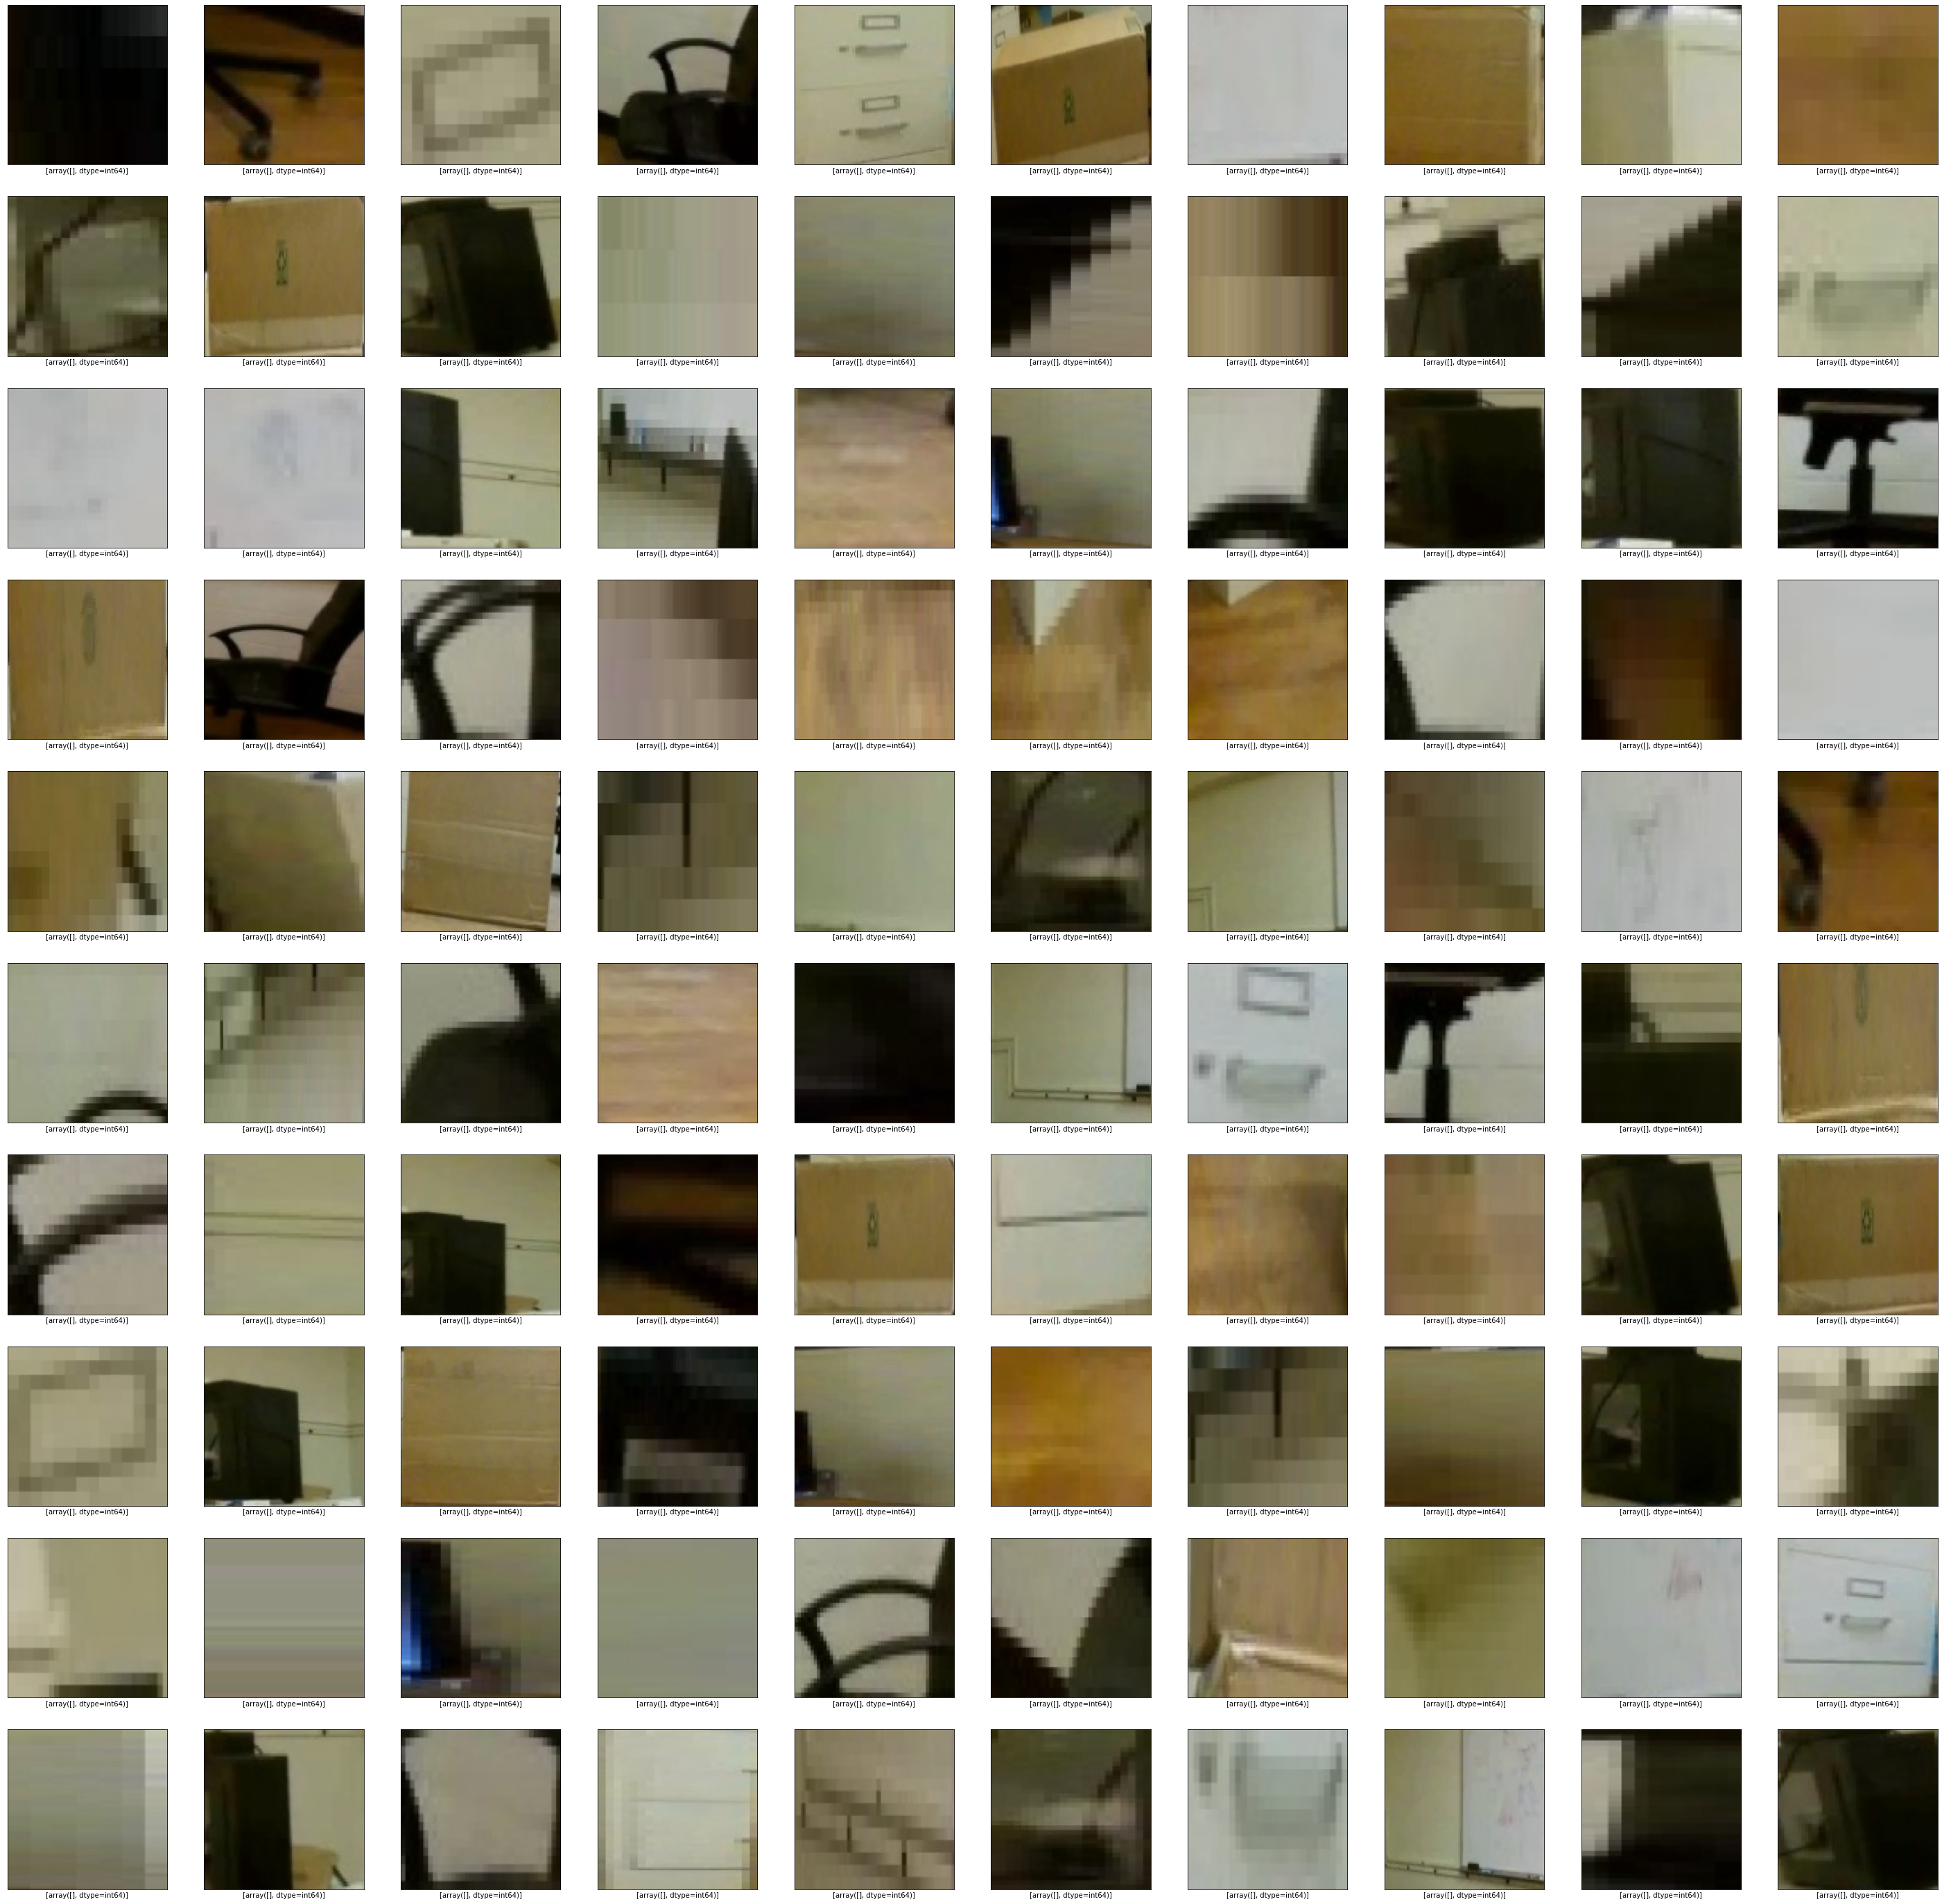

In [8]:
#Finally, Generate Images and Labels, and pickle them :) 
#---search paths
rootFolder = r"C:\Users\james\Desktop\Work_Spaces\00-School\02-Graduate\07-AdvTopicDeepLearning\00-Drone_Project"
dataSubFolder = r"04-Data\04-MODEL_1_TrainingData"
ResultsSubfolder = r"04-Data\04-MODEL_1_TrainingData"
fileSearchRE = "[a-zA-Z0-9_]+.jpg"


#--------------------------------------------- AUTOMATION SECTION --------------------------------------------------
#initialize overall timing stuff

#grab new frame manager
frameManager = FrameManager("", "", rootFolder, dataSubFolder, ResultsSubfolder, fileRegEx=fileSearchRE)
if frameManager._managerStatus is -1:
    raise RuntimeError("Bad source folder location")

#run algorithm for one set of images      
training_data = []
while(frameManager.imagesOnStack >=1): 
    #set image into selective search process and run to get boxes
    frameManager.setNextFrame()   #get next frame on stack
    c_Frame = frameManager.getCurrentFrame()
    img = c_Frame.image
#     Imaging.showImage(img)
    name = frameManager.currentImageName
    parts = name.split('_')
    label_type = parts[-1].split('.')[0]
    if label_type == "BOX":
        training_data.append([np.array(img), [0, 1]]) # BOX is 1
    elif label_type == "NOTBOX":
        training_data.append([np.array(img), [1, 0]]) # NOT BOX is 0
    else:
        raise RuntimeError("That is not an expected image.")
    

#randomize the order of images in the set
random.shuffle(training_data)

#place data and labels into files
Images = []
Labels = []
for stuff in training_data:
    if type(stuff) is not "NoneType":
        Images.append(stuff[0])
        Labels.append(stuff[1])

#reshape for purpose of training later
Images= np.array(Images).reshape(-1,ImageSize,ImageSize,3)
print("Shape of Images:", np.shape(Images))
print("Shape of Labels:", np.shape(Labels))

#write values to pickle files
#---features
pickle_out = open(os.path.join(frameManager.fullPathToResults,"Features.pickle"), "wb")
pickle.dump(Images, pickle_out)
pickle_out.close()

#---ground truths (orients)
pickle_out = open(os.path.join(frameManager.fullPathToResults,"Labels.pickle"), "wb")
pickle.dump(Labels, pickle_out)
pickle_out.close()

#test that file opens and show images
#---open features
pickle_in = open(os.path.join(frameManager.fullPathToResults,"Features.pickle"), "rb")
X = pickle.load(pickle_in)
pickle_in.close()


#---plot images with labels
plt.figure(figsize=(50, 50))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(X[i], dtype = np.uint8 ))
    plt.xlabel([np.where(Labels[i]==1)[0]])
plt.show()